## 3. Model checking

<br>

Last time we focussed on building a simple initial model for the Cepheid variable data. In this notebook, we explore the next steps in the workflow, **model implementation** and **model checking**. Along the way, we'll also introduce **prior predictive checks** and **posterior predictive checks**. 

### Implementation in Stan

<br>

In the [model building notebook](model_building.ipynb), we developed a simple model to fit the period-luminosity relation of Cepheid variable stars. We can now implement this model in Stan and use it to infer the parameters $\alpha$ and $\beta$ that describe the relation.

<br>

As we've seen before in the [introduction notebook](introduction.ipynb), Stan files consist of different blocks that divide information into `data`, `parameters` and `model`. You can find more detailed information on how to write models in Stan code [here](https://mc-stan.org/docs/2_27/reference-manual/index.html#overview), but for now we can just take a look at this model: `stan/cepheid_v0.stan`.

In [1]:
!cat stan/cepheid_v0.stan

/**
 * Initial model for Cepheid variables
 * - Single galaxy
 * - Shared sigma_m
 **/

data {

  /* usual inputs */
  int Nc; // number of Cepheids
  vector[Nc] m_obs; // obs apparent mag.
  real sigma_m; // mag uncertainty
  vector[Nc] log10P; // log10(periods/days)
  real z; // redshift of single galaxy

  /* for generated quantities */
  int Ngrid;
  vector[Ngrid] log10P_grid;
}

transformed data {

  real dL;
  
  /* luminosity distance */
  dL = (3.0e5 * z) / 70.0; // Mpc
  
}

parameters {

  /* parameters of the P-L relation */
  real alpha;
  real beta;
  
}

transformed parameters {

  vector[Nc] M_true;
  vector[Nc] m_true;

  /* P-L relation */
  M_true = alpha + beta * log10P;

  /* convert to m */
  m_true = M_true + 5 * log10(dL) + 25;
    
}

model {  

  /* likelihood */
  m_obs ~ normal(m_true, sigma_m);
  
}

generated quantities {

  vector[Ngrid] line;

  /* generate the posterior for the P-L relation */
  line = alpha + beta * log10P_grid;
  
}


A few things to note:

* We could have left the `M` <-> `m` conversion outside of Stan for a more compact program, but it is quite easy to have it inside, meaning that our work in this notebook is simplified.
* We could cut out the `transformed parameters` block and replace `m_true` with a long expression in the `model` block, but this is easy to read and gives us direct access to the `M_true` and `m_true` distributions, as we will see later.
* The `generated quantities` block is not part of the statistical model, but is run once for every iteration of the sampler. This can be useful for generating simple outputs, again as we will see later.

<br>

<u>What about priors??</u>

The more awake amongst you may notice that we have explicitly specified data, parameters and a likelihood in the Stan code, but no prior. A Bayesian analysis requires specification of the priors, so what is going on? By default, Stan will assume a uniform prior over the range of the parameters that you specified. Here, we specify `alpha` and `beta` with no bounds, and so our prior is implicitly uniform over all the real numbers. Does this sound reasonable? In any case, we will run with it for now, and talk about priors more later in this notebook.

<br>

Next, let's set up our environment and compile our model to get ready to fit some data.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import arviz as av
from cmdstanpy import CmdStanModel

In [3]:
cepheid_v0 = CmdStanModel(stan_file="stan/cepheid_v0.stan")

### The first check: fitting simulated data

<br>

While we developed our initial generative and statistical models with the goal to fit *real* data, in doing so we now have a simple simulation program that contains exactly the same information as is included in our model. We can use this to generate *simulated* data where we *know* the values of `alpha` and `beta`, and can verify that our fit gives us reasonable results. 

<br>

<img src="figures/sim_fit.png" alt="Fitting simulated data" width="300"/>

<br>

If we are not able to recover the known simulated truth, this means there is some kind of discrepancy between the generative model and the statistical model. This fact can be a **powerful tool for debugging**, especially when working with more complex models, as it allows us to check if our Stan model is doing what we think it should be. *Just because it compiles, it doesn't mean that it is correct!*

<br>

So, let's use our work in the [model building](model_building.ipynb) to simulate a test dataset using the same assumptions that we did there:

In [4]:
# known quantities
z = 0.005

Nc = 10
P = [71.5, 45.0, 19.9, 30.6, 8.8, 75.2, 21.5, 22.0, 34.5, 87.4] # days
sigma_m = 0.5

c = 3.0e5 # km/s
H0 = 70.0 # km/s/Mpc

# high-level parameter values
alpha_true = -2
beta_true = -4

You can copy over your simulation code, or load data that you saved last time. I'll load some data that I simulated earlier:

In [5]:
m_obs = np.array([21.30057715, 22.89477067, 24.63106411, 
                  22.72569458, 26.29936958, 22.34729756, 
                  24.19867534, 24.64700615, 23.19478031, 21.94968928])

We can now define our `data` dict to pass to the Stan model...

>Note: The variable names in the Stan file must match the keys of the dict

In [6]:
data = {}
data["Nc"] = Nc
data["z"] = z
data["log10P"] = np.log10(P)
data["m_obs"] = m_obs
data["sigma_m"] = sigma_m

# for generated quantities
data["Ngrid"] = 50
data["log10P_grid"] = np.linspace(0, 3)

... and try to fit the simulated data

In [7]:
# run fit
fit = cepheid_v0.sample(data=data, iter_sampling=1000, chains=4)

# check diagnostics
fit.diagnose();

# print summary
fit.summary()

17:27:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:27:17 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-4.79604,0.029499,0.988033,0.724398,-6.77793,-4.50368,-3.832770,1169.400,1523.790,1.00840
alpha,-1.28446,0.032069,0.821063,0.819522,-2.63080,-1.27179,0.018046,650.239,829.252,1.00613
beta,-4.55336,0.020668,0.525962,0.536420,-5.40481,-4.56804,-3.692100,641.744,801.387,1.00644
M_true[1],-9.72779,0.006860,0.235205,0.238350,-10.10580,-9.73338,-9.335420,1180.410,1983.250,1.00345
M_true[2],-8.81214,0.003329,0.174537,0.178053,-9.08808,-8.81455,-8.519850,2795.810,2454.620,1.00217
...,...,...,...,...,...,...,...,...,...,...
line[46],-13.82940,0.025146,0.664273,0.677326,-14.90910,-13.83000,-12.736200,693.240,1049.210,1.00542
line[47],-14.10820,0.026404,0.695545,0.709572,-15.23930,-14.10900,-12.960000,688.593,1049.410,1.00547
line[48],-14.38700,0.027663,0.726898,0.741152,-15.56790,-14.38880,-13.184300,685.201,1052.190,1.00553
line[49],-14.66580,0.028923,0.758323,0.773843,-15.89700,-14.66580,-13.409000,682.261,1037.740,1.00554


In [8]:
# to access chains of parameter values
alpha_chain = fit.stan_variable("alpha")

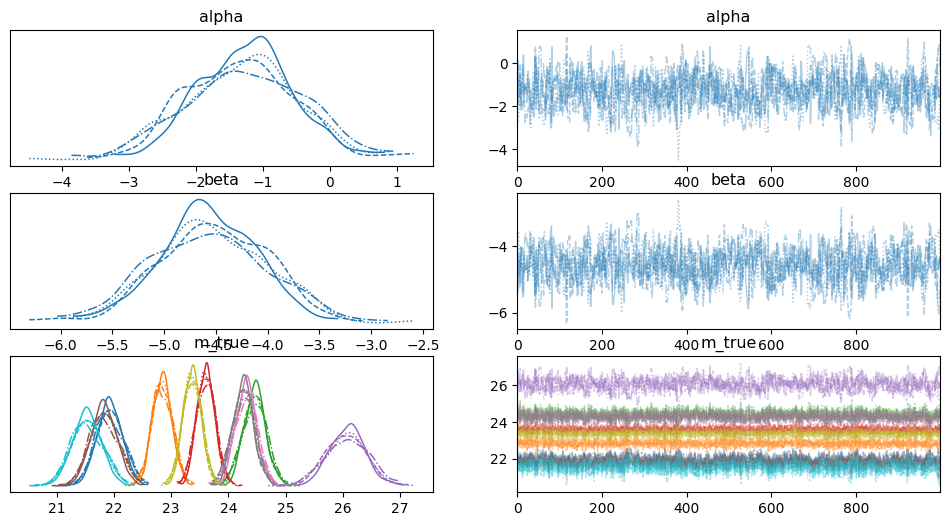

In [9]:
# plot trace
av.plot_trace(fit, var_names=["alpha", "beta", "m_true"]);

So by including `m_true` in the `transformed parameters` block, we also get the marginal distributions ready-made for free. Different chains have different linestyles and different  Cepheids have different colours in this plot.

<br>

**Exercise 1:** Looking closely, it seems that the `m_true` distributions vary from star to star, with medium `m_true` values having narrower distributions. We know `sigma_m` is fixed, so why might this be?


<span style="color:green">**Exercise 1 solution:**</span>

<span style="color:green">Think about how the line is being fit with both parameters free. We are most constrained where we have more data to pull our line into place. This will be in the "middle" of the data, where we have data points on either side. In this way, the possible true magnitudes are more constrained here, by the possible `alpha` and `beta` values. </span>

<span style="color:green">the main idea here is to realise that the `m_true` in our fit are not simply fixed by the definition of `sigma_m`, but also by the fit `alpha` and `beta`. </span>

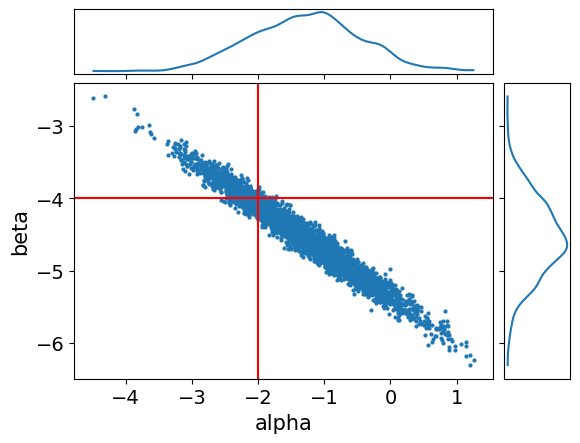

In [10]:
ax = av.plot_pair(fit, var_names=["alpha", "beta"], marginals=True)

# overlay truth in red
ax[1,0].axvline(alpha_true, color="r")
ax[1,0].axhline(beta_true, color="r")

We can see that we are able to recover the true result, although `alpha` and `beta` are quite correlated. Going back to the fit summary, we see that the number of effective samples is quite low - only ~500 for 4x1000 iterations! This fit is very fast and so we could just run it longer, but a common reparametrisation for slopes and intercepts could make the sampling much more efficient. 

<br>

**Exercise 2:** Try using the following reparametrisation for the period-luminosity relation:
$$
y = \alpha + \beta x \rightarrow y = \alpha^\prime + \beta (x - x_0)
$$
where $x_0$ is the mean value of $x$, typically called the *pivot*. Compare the number of effective samples with the previous version. Additionally, compare the joint posterior for `alpha` and `beta` with that for `alpha_prime` and `beta`. Why is this parametrisation so much more efficient?

<span style="color:green">**Exercise 2 solution:**</span>

<span style="color:green">See the Stan code needed to implement the parametrisation and results for effective sample size and `alpha_prime` vs. `beta` plot below.  </span>

In [11]:
!cat stan/cepheid_v0_rp.stan

/**
 * Initial model for Cepheid variables
 * - Single galaxy
 * - Shared sigma_m
 * - Reparametrised for efficiency
 **/

data {

  /* usual inputs */
  int Nc; // number of Cepheids
  vector[Nc] m_obs; // obs apparent mag.
  real sigma_m; // mag uncertainty
  vector[Nc] log10P; // log10(periods/days)
  real z; // redshift of single galaxy

  /* for generated quantities */
  int Ngrid;
  vector[Ngrid] log10P_grid;
}

transformed data {

  real dL;
  real pivot;
  
  /* luminosity distance */
  dL = (3.0e5 * z) / 70.0; // Mpc


  /* for reparametrisation */
  pivot = mean(log10P);
  
}

parameters {

  /* parameters of the P-L relation */
  real alpha_prime;
  real beta;
  
}

transformed parameters {

  vector[Nc] M_true;
  vector[Nc] m_true;

  real alpha;
  
  /* P-L relation */
  M_true = alpha_prime + beta * (log10P - pivot);

  /* convert to m */
  m_true = M_true + 5 * log10(dL) + 25;

  /* to compare with other results */
  alpha = alpha_prime - beta * pivot;
    
}

model {  


In [12]:
cepheid_v0_rp = CmdStanModel(stan_file="stan/cepheid_v0_rp.stan")
fit_rp = cepheid_v0_rp.sample(data=data, iter_sampling=1000, chains=4)

17:27:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:27:24 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
fit_rp.diagnose()
fit_rp.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-4.77715,0.024304,1.031670,0.689950,-6.90194,-4.45055,-3.83351,1810.53,2583.35,1.00185
alpha_prime,-8.23465,0.002613,0.159347,0.155339,-8.48918,-8.23943,-7.96676,3809.53,2772.07,1.00250
beta,-4.59130,0.009085,0.526817,0.529985,-5.44608,-4.60352,-3.74152,3397.14,2251.00,1.00045
M_true[1],-9.73879,0.004015,0.238229,0.236719,-10.11700,-9.74642,-9.34373,3549.87,2669.90,1.00063
M_true[2],-8.81551,0.002893,0.174475,0.169787,-9.09615,-8.81759,-8.52112,3719.66,2580.79,1.00180
...,...,...,...,...,...,...,...,...,...,...
line[46],-13.87460,0.011535,0.670887,0.683330,-14.94890,-13.88760,-12.75310,3409.37,2483.97,1.00089
line[47],-14.15570,0.012078,0.702261,0.714465,-15.27840,-14.16630,-12.98640,3407.54,2484.05,1.00082
line[48],-14.43680,0.012622,0.733710,0.745377,-15.61010,-14.44810,-13.21840,3406.71,2477.01,1.00089
line[49],-14.71790,0.013168,0.765227,0.777846,-15.94380,-14.73130,-13.44880,3405.34,2467.20,1.00097


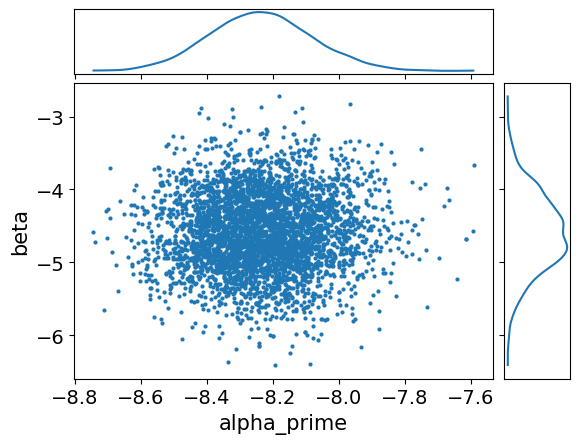

In [14]:
ax = av.plot_pair(fit_rp, var_names=["alpha_prime", "beta"], marginals=True)

<span style="color:green">So this space is easier to sample - imagine shifting our points over towards the origin. Now when we try to fit the line, we can easily explore all interesting `beta` values with a small change in `alpha_prime` and the two are less correlated than before.</span>


We can also use our `generated quantities` block to quickly visualise the posterior for the line fit:

In [15]:
line = fit.stan_variable("line")

# 4x1000 iterations, grid of Ngrid points
np.shape(line)

(4000, 50)

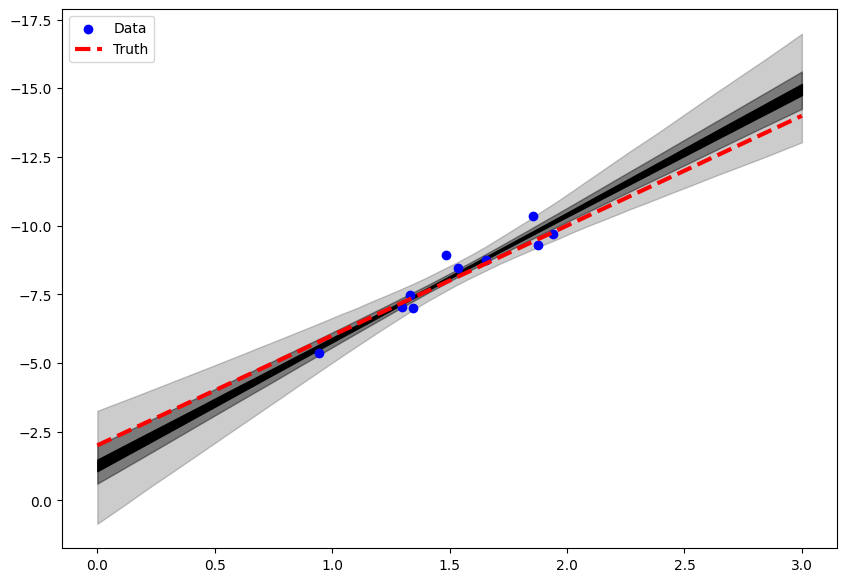

In [16]:
# get M_obs
dL = (c * z) / H0
M_obs = m_obs - 25 - 5 * np.log10(dL)

# for plot
Np = 200
log10P_grid = data["log10P_grid"]
line = fit.stan_variable("line")

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

# approximate X% regions of highest posterior density
level = 99 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=0.2)
level = 60 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=0.4)
level = 20 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=1)
ax.scatter(np.log10(P), M_obs, color="b", label="Data")
ax.plot(log10P_grid, alpha_true + beta_true * log10P_grid, color="r", lw=3, 
        linestyle="--", label="Truth")
ax.invert_yaxis()
ax.legend()


### Prior selection and prior predictive checks

As discussed in Section 3.1, we left our priors for `alpha` and `beta` to be uniform over all real numbers. In the end, this didn't seem to be a major problem and the data were informative enough to constrain the posterior. However, we should be wary of these kind of *uninformative priors*. The first motivation is common sense - from studying the data and literature, we have a fairly good idea of what the period-luminosity relationship looks like. Additionally, our sampler currently has to consider `alpha` and `beta` values from *negative to positive infinity*. 

<br>

It is rarely the case that we have zero prior knowledge on the value of our model parameters. At the same time, we don't want to bias our results by introduing too much information with so-called *informative priors*. After all, we are trying to find out what the values of `alpha` and `beta` are.

<br>

Like many things in life, there is a happy medium between these two extremes that we can use in practice. *Weakly informative priors* are wide enough to reflect our ignorance, but narrow enough to constrain the parameter space to sensible values. The exact shape of a weakly informative prior should have negligible impact on the fit results.

<br>

To help us choose sensible informative priors, we can use **prior predictive checks**. This just means sampling from the prior distribution in your generative model, and comparing the resulting data with your actual data. The idea is that the prior predictive data should  cover a wide enough region to cover all reasonable data values, and visualising priors this way in the "data-space" can be helpful in prior selection. 

<br>

**Exercise 3:** Expand your generative model to sample from the prior distributions for `alpha` and `beta`. Plot the resulting data (`m_obs` and `P`) for a few different choices of prior distributions.

<span style="color:green">**Exercise 3 solution:**</span>

<span style="color:green">See the code and plot below...</span>



In [17]:
from scipy import stats
from matplotlib import patches

In [18]:
# for calculation
dl = (c * z) / H0
log10P = np.log10(P)

# for plot
colors = plt.cm.viridis(np.linspace(0, 1, 4))
c0 = colors[0]
c2 = colors[2]

Text(0, 0.5, 'm')

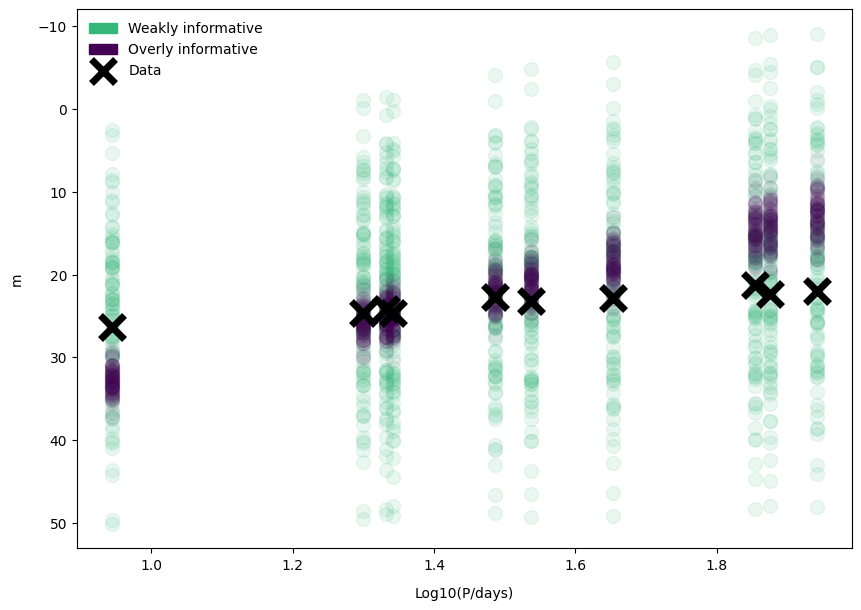

In [19]:
# Prior predictive checks
fig, ax = plt.subplots()
fig.set_size_inches((10,7))

# Weakly informative
for i in range(100):
    
    # prior samples
    alpha = np.random.normal(0, 10)
    beta = stats.truncnorm(a=-np.inf, b=(0+5)/5, loc=-5, scale=5).rvs(1)[0]
    
    # simulation
    M_true = alpha + beta * log10P
    m_true = M_true + 5 * np.log10(dl) + 25
    m_obs_pp = np.random.normal(m_true, sigma_m)

    #ax.plot(log10P_grid, alpha + beta * log10P_grid, color=c2, alpha=0.01)
    ax.scatter(log10P, m_obs_pp, color=c2, alpha=0.1, s=100, 
               label="Weakly informative")

# Overly informative
for i in range(100):
    
    # prior samples
    alpha = np.random.normal(20, 1)
    beta = np.random.normal(-20, 1)
    
    M_true = alpha + beta * log10P
    m_true = M_true + 5 * np.log10(dl) + 25
    m_obs_pp = np.random.normal(m_true, sigma_m)

    #ax.plot(log10P_grid, alpha + beta * log10P_grid, color=c0, alpha=0.01)
    ax.scatter(log10P, m_obs_pp, color=c0, alpha=0.05, s=100)

h1 = patches.Patch(color=c2, label="Weakly informative")
h2 = patches.Patch(color=c0, label="Overly informative")
h3 = ax.scatter(log10P, m_obs, s=300, color="k", zorder=10, 
                marker="x", label="Data", lw=5)
    
ax.invert_yaxis()
ax.legend(handles=[h1, h2, h3], loc="upper left", frameon=False)

ax.set_xlabel("Log10(P/days)", labelpad=10)
ax.set_ylabel("m", labelpad=10)

Your results should look something like the following:

<br>

<img src="figures/prior_predictive.png" alt="Prior predictive checks" width="500"/>

<br>

For our problem, let's update the Stan model with the following priors:

$$
\alpha \sim N(0, 10)
$$
$$
\beta \sim N(-5, 5)~\rm{for}~\beta \lt 0, 
$$
where the extra constraint on $\beta$ reflects the fact that we expect a negative slope.

The new stan model can be found in `stan/cepheid_v1.stan`. Note the `<upper=0>` syntax for parameter bounds and the new priors in the `model` block.

In [20]:
!cat stan/cepheid_v1.stan

/**
 * Initial model for Cepheid variables
 * - Single galaxy
 * - Shared sigma_m
 * - Weakly informative priors
 **/

data {

  /* usual inputs */
  int Nc; // number of Cepheids
  vector[Nc] m_obs; // obs apparent mag.
  real sigma_m; // mag uncertainty
  vector[Nc] log10P; // log10(periods/days)
  real z; // redshift of single galaxy

  /* for generated quantities */
  int Ngrid;
  vector[Ngrid] log10P_grid;
}

transformed data {

  real dL;
  
  /* luminosity distance */
  dL = (3.0e5 * z) / 70.0; // Mpc
  
}

parameters {

  /* parameters of the P-L relation */
  real alpha;
  real<upper=0> beta;
  
}

transformed parameters {

  vector[Nc] M_true;
  vector[Nc] m_true;

  /* P-L relation */
  M_true = alpha + beta * log10P;

  /* convert to m */
  m_true = M_true + 5 * log10(dL) + 25;
    
}

model {  

  /* priors */
  alpha ~ normal(0, 10);
  beta ~ normal(-5, 5);
  
  /* likelihood */
  m_obs ~ normal(m_true, sigma_m);
  
}

generated quantities {

  vector[Ngrid] line;

  /* g

Let's fit this model instead, and see how it performs.

In [21]:
stan_model = CmdStanModel(stan_file="stan/cepheid_v1.stan")
fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)

17:27:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:27:34 - cmdstanpy - INFO - CmdStan done processing.
17:27:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1.stan', line 59, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1.stan', line 59, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1.stan', line 59, column 2 to column 34)
Consider re-running with show_console=True if the above output is unclear!


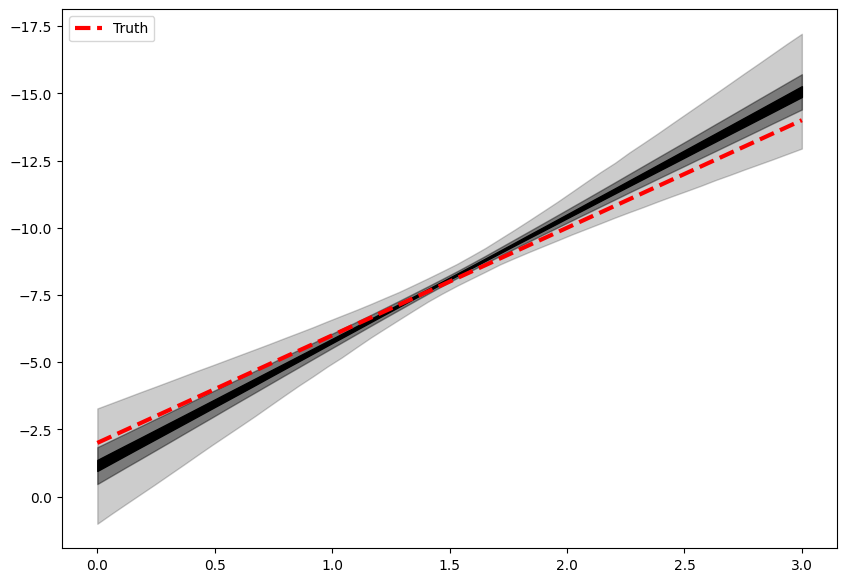

In [22]:
# for plot
log10P_grid = data["log10P_grid"]
line = fit.stan_variable("line")

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

# approximate X% regions of highest posterior density
level = 99 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=0.2)
level = 60 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=0.4)
level = 20 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=1)
ax.plot(log10P_grid, alpha_true + beta_true * log10P_grid, color="r", lw=3, 
        linestyle="--", label="Truth")
ax.invert_yaxis()
ax.legend()

We see that the prior choice has negligible impact on the results.

<br>

**Exercise 4:** Experiment with stronger priors and/or weaker data to see how this affects the inferred relation. Make some plots to visualise your results.

<span style="color:green">**Exercise 4 solution:**</span>

<span style="color:green">Stronger priors should lead to narrower posteriors, with the central value of these posteriors dependent on the choice of prior. Weaker data (e.g. removing a few data points) should lead to the posterior results becoming dominated by the specified priors.</span> 

### Posterior predictive checks

<br>

If our model fits the data well, then data generated by the model should look similar to observed data. To test if this is true, we can perform a **posterior predictive check**. 

<br>

If we have observed data $\hat{m}$ and model parameters $\alpha$ and $\beta$, we can express the joint posterior predictive distribution as
$$
p(\hat{m}_\mathrm{rep} | \hat{m}) = \int \mathrm{d}\alpha \int \mathrm{d}\beta~p(\hat{m}_\mathrm{rep}| \alpha, \beta) p(\alpha, \beta | \hat{m}),
$$
where $\hat{m}_\mathrm{rep}$ is the *replicated* data predicted by our fitted model. We can think of this as the data our model predicts we should see in future.

<br>

In practice, we can easily compute this integral using the Markov chains that we get from Stan. All we have to do is use the posterior samples for $\alpha$ and $\beta$ to forward simulate data from our likelihood, or generative model. 

**Exercise 5:** Let's compute the posterior predictive distribution for our fit to simulated data...

<span style="color:green">**Exercise 5 solution:**</span>

<span style="color:green">See code blocks below...</span>

Text(0, 0.5, 'm')

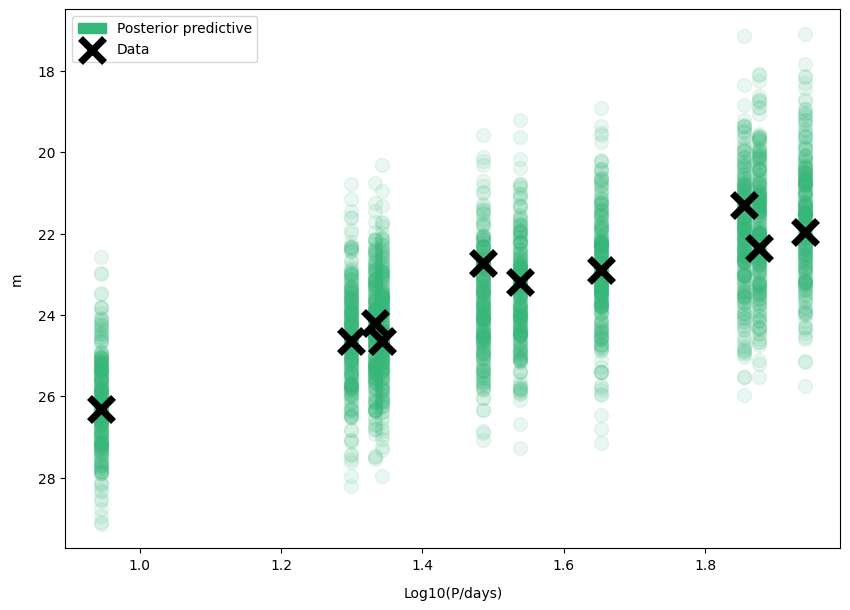

In [23]:
alpha_chain = fit.stan_variable("alpha")
beta_chain = fit.stan_variable("beta")

Nreps = 250
# sample Nreps alphas and betas
alphas = np.random.choice(alpha_chain, replace=False, size=Nreps)
betas = np.random.choice(beta_chain, replace=False, size=Nreps)

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

# for each alpha and beta
for alpha, beta in zip(alphas, betas):
    
    # simulate m_obs_rep
    M_true = alpha + beta * log10P
    m_true = M_true + 5 * np.log10(dl) + 25
    m_obs_rep = np.random.normal(m_true, sigma_m)
    
    # plot comparison of many simulated m_obs_rep datasets with m_obs used in fit
    # or equivalently for M_obs_rep/M_obs
    ax.scatter(log10P, m_obs_rep, s=100, alpha=0.1, color=c2)

h1 = patches.Patch(color=c2, label="Posterior predictive")
h2 = ax.scatter(log10P, m_obs, s=300, color="k", zorder=10, 
                marker="x", label="Data", lw=5)
ax.invert_yaxis()
ax.legend(handles=[h1, h2])
ax.set_xlabel("Log10(P/days)", labelpad=10)
ax.set_ylabel("m", labelpad=10)

Your results should look something like the following:

<br>

<img src="figures/posterior_predictive.png" alt="Posterior predictive checks" width="500"/>

<br>

There are a number of ways to study and quantify the posterior predictive distribution in order to use it to assess the "goodness of fit" of a model. Here, we only consider graphical checks, but more information can be found in Section 6.3 of [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) by Gelman et al.

### Application to actual data

<br>

**Exercise 6:** Now, let's use our `cepheid_v1.stan` model to fit the actual data introduced in the [model building notebook](model_building.ipynb). Here we have a model for one galaxy only, so let's pick one at random to start with. Complete the following steps:

* Note that the actual data have individual `sigma_m` for each Cepheid. We want to use as much information as possible, so quickly expand the Stan model to include this.
* Load the data into Stan and perform a fit. Make a plot summarising the posterior of the line fit and compare it to the `M_obs` data values. 
* Complete a posterior predictive check for this fit. 
* Repeat steps 2 and 3 for a few other galaxies to compare. Comment on the overall results. 

<span style="color:green">**Exercise 6 solution:**</span>

<span style="color:green">See code blocks below...</span>

In [24]:
# new stan model
!cat stan/cepheid_v1_sigmam.stan

stan_model = CmdStanModel(stan_file="stan/cepheid_v1_sigmam.stan")

/**
 * Initial model for Cepheid variables
 * - Single galaxy
 * - Individual sigma_m's
 * - Weakly informative priors
 **/

data {

  /* usual inputs */
  int Nc; // number of Cepheids
  vector[Nc] m_obs; // obs apparent mag.
  vector[Nc] sigma_m; // mag uncertainty
  vector[Nc] log10P; // log10(periods/days)
  real z; // redshift of single galaxy

  /* for generated quantities */
  int Ngrid;
  vector[Ngrid] log10P_grid;
}

transformed data {

  real dL;
  
  /* luminosity distance */
  dL = (3.0e5 * z) / 70.0; // Mpc
  
}

parameters {

  /* parameters of the P-L relation */
  real alpha;
  real<upper=0> beta;
  
}

transformed parameters {

  vector[Nc] M_true;
  vector[Nc] m_true;

  /* P-L relation */
  M_true = alpha + beta * log10P;

  /* convert to m */
  m_true = M_true + 5 * log10(dL) + 25;
    
}

model {  

  /* priors */
  alpha ~ normal(0, 10);
  beta ~ normal(-5, 5);
  
  /* likelihood */
  m_obs ~ normal(m_true, sigma_m);
  
}

generated quantities {

  vector[Ngrid] l

In [25]:
# load data
galaxy_info = np.loadtxt("data/galaxies.dat")
cepheid_info = np.loadtxt("data/cepheids.dat")

# reorganise the data into a dictionary indexed by the galaxy number
galaxies = [int(ngc_no) for ngc_no in galaxy_info[:, 0]]
data = {int(x[0]):{"z":x[1]} for x in galaxy_info}

for g in galaxies:
    j = np.where(cepheid_info[:, 0] == g)[0]
    data[g]["gal"] = np.array([int(i) for i in cepheid_info[j, 0]])
    data[g]["Nc"] = len(data[g]["gal"])
    data[g]["m_obs"] = cepheid_info[j, 1]
    data[g]["sigma_m"] = cepheid_info[j, 2]
    data[g]["P"] = cepheid_info[j, 3]
    data[g]["delta_logO_H"] = cepheid_info[j, 4]
    data[g]["log10P"] = np.log10(data[g]["P"])

# pick a galaxy
g = galaxies[0]

In [26]:
# data for stan
input_data = {}
input_data["Nc"] = data[g]["Nc"]
input_data["log10P"] = data[g]["log10P"]
input_data["m_obs"] = data[g]["m_obs"]
input_data["sigma_m"] = data[g]["sigma_m"]
input_data["z"] = data[g]["z"]
input_data["Ngrid"] = 50
input_data["log10P_grid"] = np.linspace(0, 3)

In [27]:
# fit
fit = stan_model.sample(data=input_data, iter_sampling=1000, chains=4)

# usual checks
fit.diagnose()
fit.summary()

17:27:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:27:45 - cmdstanpy - INFO - CmdStan done processing.
17:27:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1_sigmam.stan', line 59, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1_sigmam.stan', line 59, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1_sigmam.stan', line 59, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1_sigmam.stan', line 59, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1_sigmam.stan', line 59, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v1_sigmam.stan', line 59, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -in

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-602.26300,0.029583,0.987013,0.705718,-604.33000,-601.95200,-601.30400,1309.330,1482.580,0.999967
alpha,-1.84152,0.005148,0.137954,0.143123,-2.07602,-1.83787,-1.62452,720.177,848.635,1.005390
beta,-4.17300,0.003453,0.091319,0.094442,-4.31510,-4.17512,-4.02150,700.076,844.570,1.005010
M_true[1],-8.54494,0.000606,0.030505,0.030883,-8.59556,-8.54515,-8.49537,2561.000,2746.190,1.000910
M_true[2],-7.11664,0.000880,0.034339,0.034589,-7.17347,-7.11651,-7.06133,1538.340,1996.210,1.002590
...,...,...,...,...,...,...,...,...,...,...
line[46],-13.33850,0.004404,0.119914,0.125650,-13.53310,-13.33890,-13.14310,741.178,1052.570,1.004330
line[47],-13.59400,0.004614,0.125354,0.131655,-13.79700,-13.59440,-13.39030,737.757,1050.910,1.004370
line[48],-13.84950,0.004825,0.130808,0.137066,-14.06070,-13.85000,-13.63760,734.529,1008.490,1.004420
line[49],-14.10500,0.005036,0.136273,0.143219,-14.32510,-14.10530,-13.88310,731.603,994.649,1.004460


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

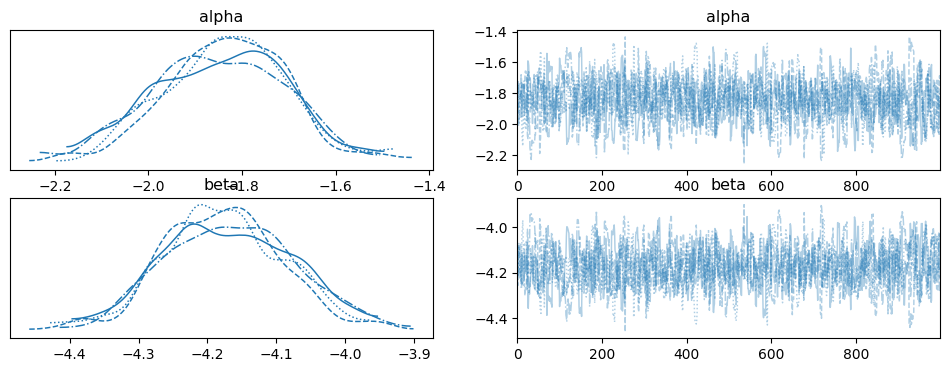

In [28]:
av.plot_trace(fit, var_names=["alpha", "beta"])

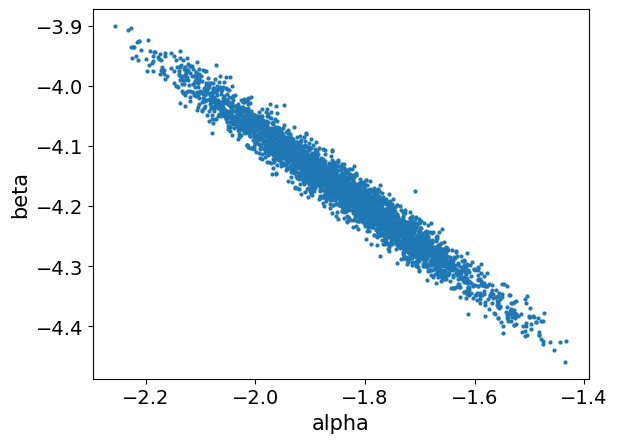

In [29]:
ax = av.plot_pair(fit, var_names=["alpha", "beta"]);

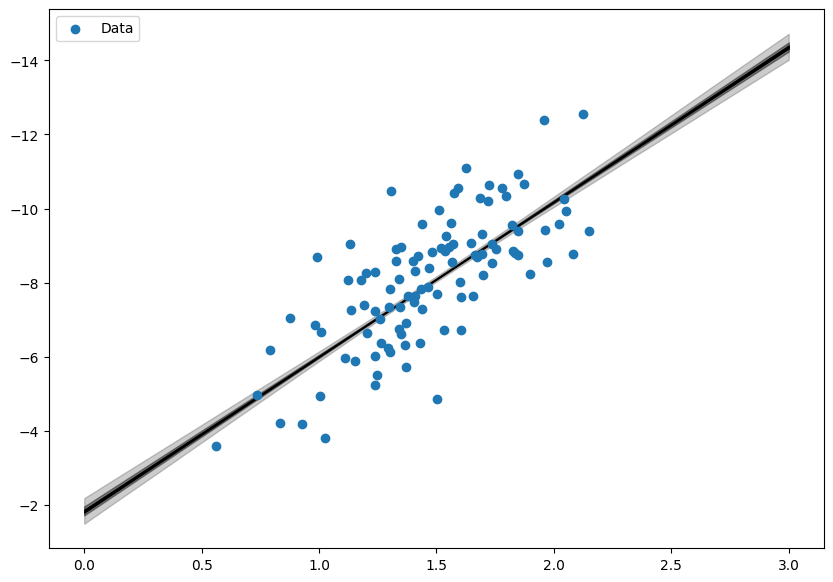

In [30]:
# plot line posterior
log10P_grid = input_data["log10P_grid"]
line = fit.stan_variable("line")

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

# approximate X% regions of highest posterior density
level = 99 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=0.2)
level = 60 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=0.4)
level = 20 #%
ax.fill_between(log10P_grid, np.percentile(line, 50 - 0.5*level, axis=0), 
               np.percentile(line, 50 + 0.5*level, axis=0), color="k", alpha=1)

dl = (c * input_data["z"]) / H0
M_obs = input_data["m_obs"] - 5*np.log10(dl) - 25

ax.scatter(input_data["log10P"], M_obs, label="Data")
ax.legend()
ax.invert_yaxis()

Text(0, 0.5, 'M')

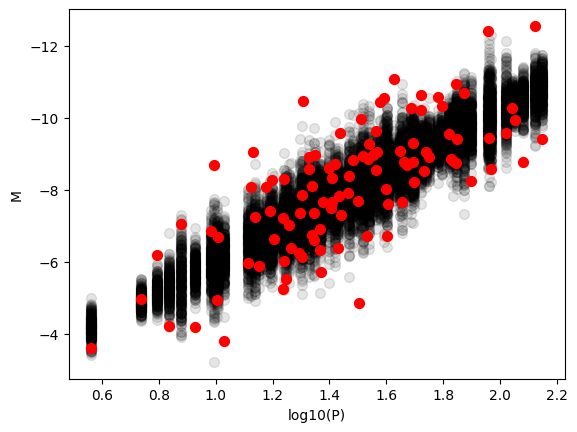

In [31]:
# posterior predictive check
Nrep = 250

# if not already defined
c = 3.0e5
H0 = 70.0
dl = (c * data[g]["z"]) / H0

alphas = np.random.choice(fit.stan_variable("alpha"), replace=False, size=Nrep)
betas = np.random.choice(fit.stan_variable("beta"), replace=False, size=Nrep)

fig, ax = plt.subplots()

for alpha, beta in zip(alphas, betas):

    M_true = alpha + beta * data[g]["log10P"] 

    m_true = M_true + 25 + 5 * np.log10(dl)

    m_obs_rep = np.random.normal(m_true, input_data["sigma_m"])

    M_obs_rep = m_obs_rep - 25 - 5*np.log10(dl)
    
    ax.scatter(data[g]["log10P"], M_obs_rep, color="k", alpha=0.1, s=50)
ax.scatter(data[g]["log10P"], data[g]["m_obs"] -25 - 5 * np.log10(dl), color="r", s=50)
ax.invert_yaxis()
ax.set_xlabel("log10(P)")
ax.set_ylabel("M")

<span style="color:green">So, we note that our posterior predictive checks are clearly not able to reproduce the spread of our data. We should see similar results across all the different galaxies.</span>

The above exercise should leave us feeling unsatisfied with out model. We seek out an expert to discuss with, and learn the following information:
* The metallicity of a Cepheid has a systematic effect on its intrinsic brightness, shifting it by a factor of $\gamma=1.5$

<br>

**Exercise 7:** Use the above information together with the completed posterior predictive checks to improve your Stan model. Once you are satisfied with your single galaxy model, save it as `cepheid_v2.stan`, and make some plots arguing your case.

<span style="color:green">**Exercise 7 solution**</span>

<span style="color:green">Here, we show an implementation of the metallicity effect and the resulting PPCs.</span>

In [32]:
!cat stan/cepheid_v2.stan

stan_model = CmdStanModel(stan_file="stan/cepheid_v2.stan")

/**
 * Initial model for Cepheid variables
 * - Single galaxy
 * - Individual sigma_m's
 * - Weakly informative priors
 **/

data {

  /* usual inputs */
  int Nc; // number of Cepheids
  vector[Nc] m_obs; // obs apparent mag.
  vector[Nc] sigma_m; // mag uncertainty
  vector[Nc] log10P; // log10(periods/days)
  vector[Nc] delta_logO_H; // metallicity proxy
  real z; // redshift of single galaxy

  /* for generated quantities */
  int Ngrid;
  vector[Ngrid] log10P_grid;
}

transformed data {

  real dL;
  
  /* luminosity distance */
  dL = (3.0e5 * z) / 70.0; // Mpc

}

parameters {

  /* parameters of the P-L relation */
  real alpha;
  real<upper=0> beta;

  //vector[Nc] log10P_true;
}

transformed parameters {

  vector[Nc] M_true;
  vector[Nc] m_true;
  
  /* P-L relation */
  M_true = alpha + (beta * log10P) + (1.5 * delta_logO_H);

  /* convert to m */
  m_true = M_true + 5 * log10(dL) + 25;
    
}

model {  

  /* priors */
  alpha ~ normal(0, 10);
  beta ~ normal(-5, 5);
  
  

In [33]:
input_data = {}
input_data["Nc"] = data[g]["Nc"]
input_data["log10P"] = data[g]["log10P"]
input_data["m_obs"] = data[g]["m_obs"]
input_data["sigma_m"] = data[g]["sigma_m"]
input_data["z"] = data[g]["z"]
input_data["delta_logO_H"] = data[g]["delta_logO_H"]
input_data["Ngrid"] = 50
input_data["log10P_grid"] = np.linspace(0, 3)

fit = stan_model.sample(data=input_data, iter_sampling=1000, chains=4)

fit.diagnose()
fit.summary()

17:28:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:02 - cmdstanpy - INFO - CmdStan done processing.
17:28:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-58.44690,0.028034,0.920170,0.686889,-60.36340,-58.16110,-57.55570,1165.960,1618.180,1.00363
alpha,-2.45271,0.004974,0.127909,0.131937,-2.66641,-2.45020,-2.24657,665.712,653.054,1.00495
beta,-3.83081,0.003296,0.083661,0.084708,-3.96571,-3.83442,-3.68953,649.716,585.126,1.00505
M_true[1],-8.03721,0.000537,0.029840,0.029741,-8.08686,-8.03729,-7.98809,3102.820,2520.540,1.00243
M_true[2],-7.66548,0.000894,0.034035,0.033863,-7.72139,-7.66544,-7.60825,1463.120,1807.970,1.00171
...,...,...,...,...,...,...,...,...,...,...
line[46],-13.00700,0.004149,0.109448,0.110602,-13.18560,-13.01020,-12.81990,705.653,645.699,1.00440
line[47],-13.24150,0.004350,0.114404,0.115198,-13.42770,-13.24540,-13.04540,701.070,639.761,1.00444
line[48],-13.47610,0.004551,0.119375,0.120387,-13.67000,-13.47990,-13.27170,697.683,642.792,1.00449
line[49],-13.71060,0.004752,0.124358,0.125354,-13.91210,-13.71480,-13.49720,694.603,642.792,1.00456


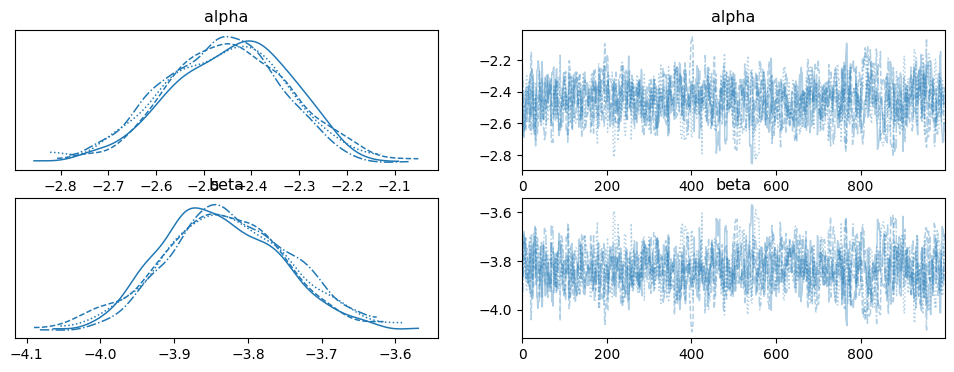

In [34]:
av.plot_trace(fit, var_names=["alpha", "beta"]);

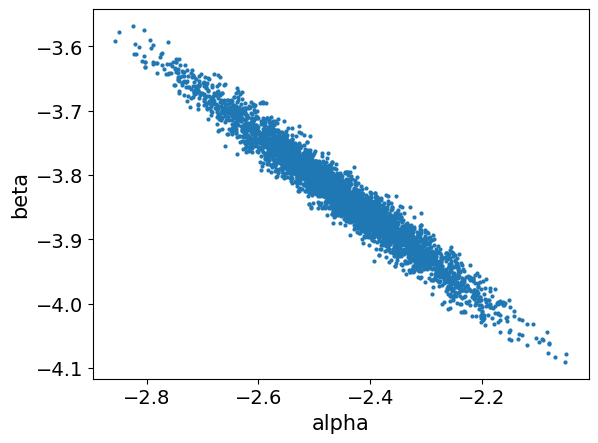

In [35]:
ax = av.plot_pair(fit, var_names=["alpha", "beta"]);

Text(0, 0.5, 'M')

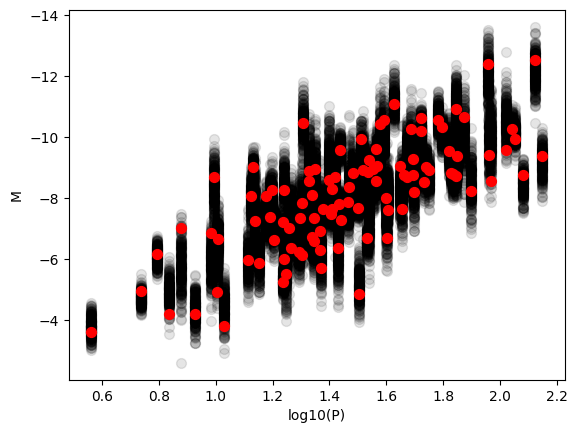

In [36]:
# posterior predictive check
Nrep = 250

# if not already defined
c = 3.0e5
H0 = 70.0
dl = (c * data[g]["z"]) / H0

gamma = 1.5
alphas = np.random.choice(fit.stan_variable("alpha"), replace=False, size=Nrep)
betas = np.random.choice(fit.stan_variable("beta"), replace=False, size=Nrep)

fig, ax = plt.subplots()

for alpha, beta in zip(alphas, betas):

    M_true = alpha + beta * data[g]["log10P"] + gamma * data[g]["delta_logO_H"]

    m_true = M_true + 25 + 5 * np.log10(dl)

    m_obs_rep = np.random.normal(m_true, input_data["sigma_m"])

    M_obs_rep = m_obs_rep - 25 - 5*np.log10(dl)
    
    ax.scatter(data[g]["log10P"], M_obs_rep, color="k", alpha=0.1, s=50)
ax.scatter(data[g]["log10P"], data[g]["m_obs"] -25 - 5 * np.log10(dl), color="r", s=50)
ax.invert_yaxis()
ax.set_xlabel("log10(P)")
ax.set_ylabel("M")

<span style="color:green">This model looks much better, as it is capable of producing all observed data points.</span>

**Exercise 8:** Use your improved model, `cepheid_v2.stan` to fit the data from each galaxy independently. Make some plots showing the resulting `alpha` and `beta` marginal posteriors for the different galaxies (e.g. ridgeline plots can be a nice way to show this). What can you conclude about the universailty of the period-luminosity relation?

<span style="color:green">**Exercise 8 solution**</span>

<span style="color:green">See below...</span>

In [37]:
stan_model = CmdStanModel(stan_file="stan/cepheid_v2.stan")

fits = []

for g in galaxies:
    input_data = {}
    input_data["Nc"] = data[g]["Nc"]
    input_data["log10P"] = data[g]["log10P"]
    input_data["m_obs"] = data[g]["m_obs"]
    input_data["sigma_m"] = data[g]["sigma_m"]
    input_data["z"] = data[g]["z"]
    input_data["delta_logO_H"] = data[g]["delta_logO_H"]
    input_data["Ngrid"] = 50
    input_data["log10P_grid"] = np.linspace(0, 3)
    
    fit = stan_model.sample(data=input_data, iter_sampling=1000, chains=4)
    fits.append(fit)

17:28:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:06 - cmdstanpy - INFO - CmdStan done processing.
17:28:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:07 - cmdstanpy - INFO - CmdStan done processing.
17:28:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:07 - cmdstanpy - INFO - CmdStan done processing.
17:28:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Consider re-running with show_console=True if the above output is unclear!
17:28:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:07 - cmdstanpy - INFO - CmdStan done processing.
17:28:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:08 - cmdstanpy - INFO - CmdStan done processing.
17:28:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:08 - cmdstanpy - INFO - CmdStan done processing.
17:28:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:08 - cmdstanpy - INFO - CmdStan done processing.
17:28:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:09 - cmdstanpy - INFO - CmdStan done processing.
17:28:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:28:09 - cmdstanpy - INFO - CmdStan done processing.
17:28:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.stan', line 61, column 2 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'cepheid_v2.sta

In [38]:
for fit in fits:
    print(fit.diagnose());

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergen

Text(0.5, 0, 'beta')

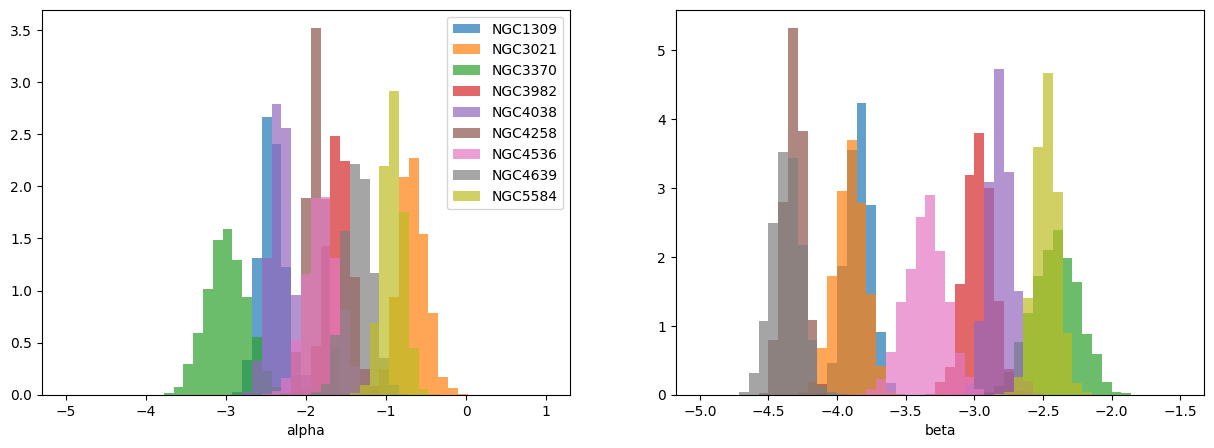

In [39]:
# plot: this could be made more nicely :)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

alpha_bins = np.linspace(-5, 1)
beta_bins = np.linspace(-5, -1.5)

for fit, g in zip(fits, galaxies):
    ax[0].hist(fit.stan_variable("alpha"), bins=alpha_bins, 
               density=True, label="NGC%i"%g, alpha=0.7)
    ax[1].hist(fit.stan_variable("beta"), bins=beta_bins, 
               density=True, label="NGC%i"%g, alpha=0.7)
ax[0].legend()
ax[0].set_xlabel("alpha")
ax[1].set_xlabel("beta")

<span style="color:green">The parameter posteriors are grouped around similar values and overlap, but the full range of values is broader than the width of any single distribution. In this way we expect that universal relation is plausible, but there are differences in the galaxy levels. </span>

In [40]:
import h5py

In [41]:
# save data for later comparison:
with h5py.File("data/cepheid_individual_fits.h5", "w") as f:
    for fit, g in zip(fits, galaxies):
        group = f.create_group("%i"%g)
        group.create_dataset("alpha", data=fit.stan_variable("alpha"))
        group.create_dataset("beta", data=fit.stan_variable("beta"))

### Further reading

<br>

* Weakly informative priors: Simpson, D., Rue, H., Riebler, A., Martins, T. G. & Sørbye, S. H. Penalising Model Component Complexity: A Principled, Practical Approach to Constructing Priors. Statistical Science 32, 1–28 (2017). [DOI: 10.1214/16-STS576](https://projecteuclid.org/journals/statistical-science/volume-32/issue-1/Penalising-Model-Component-Complexity--A-Principled-Practical-Approach-to/10.1214/16-STS576.full).
  
* Posterior predictive checks: Section 6.3 of [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) by Gelman et al.